In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import pandas as pd
from tqdm import tqdm


Compute Device: cuda
Files already downloaded and verified


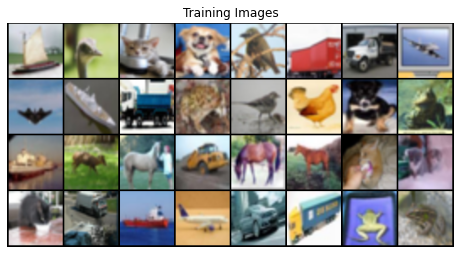

In [2]:

torch.manual_seed(1)
compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Compute Device:', compute_device)
learning_rate = 2e-4
batch_size = 128
image_size = 64
image_channels = 3
noise_dimension = 100
total_epochs = 50
discriminator_features = 64
generator_features = 64
momentum_beta = 0.5
data_set = datasets.CIFAR10(root="./dataset/CIFAR10data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                         shuffle=True, num_workers=2)
# Plotting training images
initial_batch = next(iter(data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(initial_batch[0].to(compute_device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))


In [3]:
def set_weights(model):
    for mod in model.modules():
        if isinstance(mod, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(mod.weight.data, 0.0, 0.02)

class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self.create_disc_block(features_d, features_d * 2, 4, 2, 1),
            self.create_disc_block(features_d * 2, features_d * 4, 4, 2, 1),
            self.create_disc_block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def create_disc_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.main(x)

discriminator = Discriminator(image_channels, discriminator_features).to(compute_device)
set_weights(discriminator)

class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            self.create_gen_block(channels_noise, features_g * 16, 4, 1, 0),
            self.create_gen_block(features_g * 16, features_g * 8, 4, 2, 1),
            self.create_gen_block(features_g * 8, features_g * 4, 4, 2, 1),
            self.create_gen_block(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def create_gen_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels, momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.main(x)

generator = Generator(noise_dimension, image_channels, generator_features).to(compute_device)
set_weights(generator)
optimizer_gen = optim.Adam(generator.parameters(), lr=learning_rate, betas=(momentum_beta, 0.999))
optimizer_disc = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(momentum_beta, 0.999))
loss_function = nn.BCELoss()
static_noise = torch.randn(32, noise_dimension, 1, 1).to(compute_device) 
iteration = 0
generator.train(), discriminator.train()

(Generator(
   (main): Sequential(
     (0): Sequential(
       (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
       (1): BatchNorm2d(1024, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (1): Sequential(
       (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Sequential(
       (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (4): 

In [4]:
from torchvision.models import inception_v3

def inception_features(resize_input=True, normalize_input=True, requires_grad=False):
    class InceptionV3Wrapper(nn.Module):
        DEFAULT_BLOCK_INDEX = 3
        BLOCK_INDEX_BY_DIM = {64: 0, 192: 1, 768: 2, 2048: 3}

        def __init__(self, output_blocks=[DEFAULT_BLOCK_INDEX]):
            super(InceptionV3Wrapper, self).__init__()
            self.resize_input = resize_input
            self.normalize_input = normalize_input
            self.output_blocks = sorted(output_blocks)
            self.last_needed_block = max(output_blocks)
            assert self.last_needed_block <= 3, 'Last possible output block index is 3'
            self.blocks = nn.ModuleList()
            inception = inception_v3(pretrained=True)
            block0 = [inception.Conv2d_1a_3x3, inception.Conv2d_2a_3x3, inception.Conv2d_2b_3x3, nn.MaxPool2d(kernel_size=3, stride=2)]
            self.blocks.append(nn.Sequential(*block0))
            if self.last_needed_block >= 1:
                block1 = [inception.Conv2d_3b_1x1, inception.Conv2d_4a_3x3, nn.MaxPool2d(kernel_size=3, stride=2)]
                self.blocks.append(nn.Sequential(*block1))
            if self.last_needed_block >= 2:
                block2 = [inception.Mixed_5b, inception.Mixed_5c, inception.Mixed_5d, inception.Mixed_6a, inception.Mixed_6b, inception.Mixed_6c, inception.Mixed_6d, inception.Mixed_6e]
                self.blocks.append(nn.Sequential(*block2))
            if self.last_needed_block >= 3:
                block3 = [inception.Mixed_7a, inception.Mixed_7b, inception.Mixed_7c, nn.AdaptiveAvgPool2d(output_size=(1, 1))]
                self.blocks.append(nn.Sequential(*block3))
            for param in self.parameters():
                param.requires_grad = requires_grad

        def forward(self, inp):
            outp = []
            x = inp
            if self.resize_input:
                x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
            if self.normalize_input:
                x = 2 * x - 1
            for idx, block in enumerate(self.blocks):
                x = block(x)
                if idx in self.output_blocks:
                    outp.append(x)
                if idx == self.last_needed_block:
                    break
            return outp
    return InceptionV3Wrapper([InceptionV3Wrapper.BLOCK_INDEX_BY_DIM[2048]])


inception_model = inception_features().to(compute_device)


def get_activations(images, model, batch_size=128, dims=2048, cuda=False):
    model.eval()
    activations = np.empty((len(images), dims))
    if cuda:
        batch = images.cuda()
    else:
        batch = images
    prediction = model(batch)[0]
    if prediction.size(2) != 1 or prediction.size(3) != 1:
        prediction = F.adaptive_avg_pool2d(prediction, output_size=(1, 1))
    activations = prediction.cpu().data.numpy().reshape(prediction.size(0), -1)
    mean_act = np.mean(activations, axis=0)
    sigma_act = np.cov(activations, rowvar=False)
    return mean_act, sigma_act

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1, mu2 = np.atleast_1d(mu1), np.atleast_1d(mu2)
    sigma1, sigma2 = np.atleast_2d(sigma1), np.atleast_2d(sigma2)
    assert mu1.shape == mu2.shape and sigma1.shape == sigma2.shape, "Mean and covariance matrices must have the same dimensions"
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = f'Adding {eps} to diagonal of covariance estimates'
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError(f'Imaginary component {m}')
        covmean = covmean.real
    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

def calculate_fid(real_images, fake_images, model):
    mu_real, sigma_real = get_activations(real_images, model, cuda=True)
    mu_fake, sigma_fake = get_activations(fake_images, model, cuda=True)
    fid_score = calculate_frechet_distance(mu_real, sigma_real, mu_fake, sigma_fake)
    return fid_score

gen_losses, disc_losses = [], []
image_progress, fid_scores = [], []
current_iteration = 0

/home/jkoduri/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jkoduri/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:

time_start = time.time()
epoch_count = 0
while epoch_count < total_epochs:
    epoch_count += 1
    for batch_index, data in tqdm(enumerate(data_loader, 0)):
        real_images = data[0].to(compute_device)
        noise = torch.randn(batch_size, noise_dimension, 1, 1).to(compute_device)
        generated_images = generator(noise)

        discriminator_real = discriminator(real_images).reshape(-1)
        loss_discriminator_real = loss_function(discriminator_real, torch.ones_like(discriminator_real))
        discriminator_fake = discriminator(generated_images.detach()).reshape(-1)
        loss_discriminator_fake = loss_function(discriminator_fake, torch.zeros_like(discriminator_fake))
        loss_discriminator = (loss_discriminator_real + loss_discriminator_fake) / 2
        discriminator.zero_grad()
        loss_discriminator.backward()
        optimizer_disc.step()

        output = discriminator(generated_images).reshape(-1)
        loss_generator = loss_function(output, torch.ones_like(output))
        generator.zero_grad()
        loss_generator.backward()
        optimizer_gen.step()

        gen_losses.append(loss_generator.detach().cpu())
        disc_losses.append(loss_discriminator.detach().cpu())

        if (current_iteration % 500 == 0) or ((epoch_count == total_epochs) and (batch_index == len(data_loader)-1)):
            with torch.no_grad():
                fixed_generated_images = generator(static_noise).detach().cpu()
            image_progress.append(utils.make_grid(fixed_generated_images, padding=2, normalize=True))

        current_iteration += 1

    fid_value = calculate_fid(real_images, generated_images, inception_model)
    fid_scores.append(fid_value)
    print(f'\nEpoch [{epoch_count}/{total_epochs}] Loss Discriminator: {loss_discriminator:.3f}, Loss Generator: {loss_generator:.3f} FID: {fid_value:.3f}')

time_end = time.time()
print(f'\nElapsed time: {time_end - time_start:.2f} s.')


391it [00:34, 11.41it/s]



Epoch [1/50] Loss Discriminator: 0.343, Loss Generator: 1.813 FID: 356.367


391it [00:32, 12.08it/s]



Epoch [2/50] Loss Discriminator: 0.491, Loss Generator: 1.473 FID: 460.970


391it [00:32, 12.07it/s]



Epoch [3/50] Loss Discriminator: 0.504, Loss Generator: 1.528 FID: 401.074


391it [00:32, 12.06it/s]



Epoch [4/50] Loss Discriminator: 0.678, Loss Generator: 0.990 FID: 363.960


391it [00:32, 12.04it/s]



Epoch [5/50] Loss Discriminator: 0.622, Loss Generator: 1.628 FID: 265.126


391it [00:32, 12.03it/s]



Epoch [6/50] Loss Discriminator: 0.678, Loss Generator: 1.081 FID: 244.968


391it [00:32, 12.02it/s]



Epoch [7/50] Loss Discriminator: 0.621, Loss Generator: 0.825 FID: 246.570


391it [00:32, 12.03it/s]



Epoch [8/50] Loss Discriminator: 0.617, Loss Generator: 1.342 FID: 228.375


391it [00:32, 12.02it/s]



Epoch [9/50] Loss Discriminator: 0.636, Loss Generator: 1.059 FID: 221.318


391it [00:32, 12.04it/s]



Epoch [10/50] Loss Discriminator: 0.573, Loss Generator: 0.893 FID: 216.197


391it [00:32, 12.03it/s]



Epoch [11/50] Loss Discriminator: 0.674, Loss Generator: 0.877 FID: 212.235


391it [00:32, 12.04it/s]



Epoch [12/50] Loss Discriminator: 0.646, Loss Generator: 0.756 FID: 211.470


391it [00:32, 12.05it/s]



Epoch [13/50] Loss Discriminator: 0.676, Loss Generator: 0.841 FID: 215.470


391it [00:32, 12.05it/s]



Epoch [14/50] Loss Discriminator: 0.602, Loss Generator: 1.321 FID: 204.955


391it [00:32, 12.05it/s]



Epoch [15/50] Loss Discriminator: 0.599, Loss Generator: 0.763 FID: 194.113


391it [00:32, 12.04it/s]



Epoch [16/50] Loss Discriminator: 0.636, Loss Generator: 0.951 FID: 192.739


391it [00:32, 12.07it/s]



Epoch [17/50] Loss Discriminator: 0.634, Loss Generator: 0.926 FID: 182.539


391it [00:32, 12.05it/s]



Epoch [18/50] Loss Discriminator: 0.697, Loss Generator: 0.803 FID: 183.145


391it [00:32, 12.06it/s]



Epoch [19/50] Loss Discriminator: 0.663, Loss Generator: 1.080 FID: 190.138


391it [00:32, 12.06it/s]



Epoch [20/50] Loss Discriminator: 0.666, Loss Generator: 0.891 FID: 199.615


391it [00:32, 12.03it/s]



Epoch [21/50] Loss Discriminator: 0.615, Loss Generator: 1.156 FID: 186.364


391it [00:32, 12.03it/s]



Epoch [22/50] Loss Discriminator: 0.514, Loss Generator: 1.108 FID: 198.114


391it [00:32, 12.06it/s]



Epoch [23/50] Loss Discriminator: 0.501, Loss Generator: 0.935 FID: 186.455


391it [00:32, 12.05it/s]



Epoch [24/50] Loss Discriminator: 0.648, Loss Generator: 0.925 FID: 207.206


391it [00:32, 12.06it/s]



Epoch [25/50] Loss Discriminator: 0.592, Loss Generator: 0.971 FID: 187.944


391it [00:32, 12.05it/s]



Epoch [26/50] Loss Discriminator: 0.663, Loss Generator: 0.718 FID: 187.771


391it [00:32, 12.05it/s]



Epoch [27/50] Loss Discriminator: 0.573, Loss Generator: 1.023 FID: 183.824


391it [00:32, 12.06it/s]



Epoch [28/50] Loss Discriminator: 0.436, Loss Generator: 1.394 FID: 182.836


391it [00:32, 12.05it/s]



Epoch [29/50] Loss Discriminator: 0.604, Loss Generator: 1.189 FID: 189.097


391it [00:32, 12.06it/s]



Epoch [30/50] Loss Discriminator: 0.490, Loss Generator: 1.465 FID: 185.052


391it [00:32, 12.04it/s]



Epoch [31/50] Loss Discriminator: 0.539, Loss Generator: 1.076 FID: 182.144


391it [00:32, 12.06it/s]



Epoch [32/50] Loss Discriminator: 0.466, Loss Generator: 1.382 FID: 185.410


391it [00:32, 12.07it/s]



Epoch [33/50] Loss Discriminator: 0.653, Loss Generator: 0.967 FID: 175.703


391it [00:32, 12.06it/s]



Epoch [34/50] Loss Discriminator: 0.628, Loss Generator: 1.110 FID: 182.258


320it [00:26, 12.04it/s]


KeyboardInterrupt: 

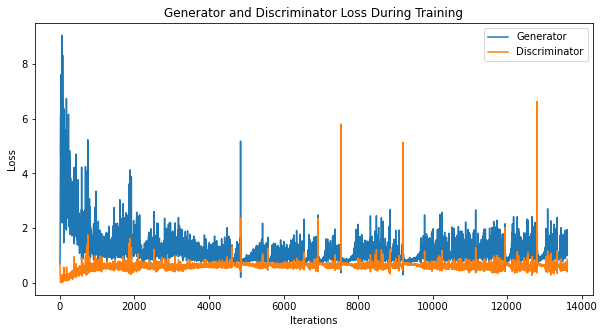

In [6]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_losses, label="Generator")
plt.plot(disc_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

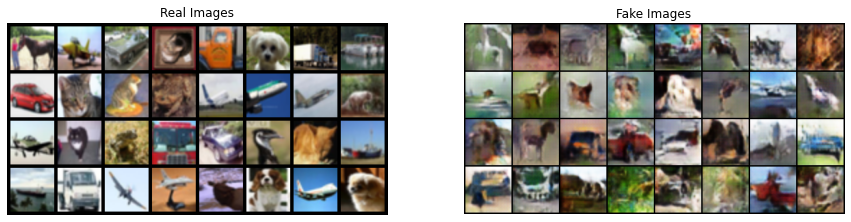

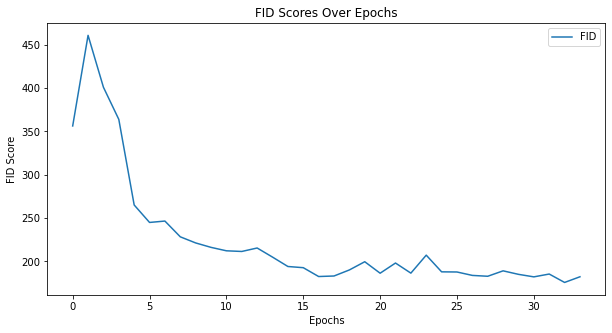

In [7]:
final_batch = next(iter(data_loader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(final_batch[0].to(compute_device)[:32], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(image_progress[-1],(1,2,0)))
plt.show()

plt.figure(figsize=(10,5))
plt.title("FID Scores Over Epochs")
plt.plot(fid_scores, label="FID")
plt.xlabel("Epochs")
plt.ylabel("FID Score")
plt.legend()
plt.show()

In [8]:
np.mean(fid_scores), fid_scores[-1]

(223.86825247302454, 182.2578447798913)